In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from tqdm.auto import tqdm
from torch import nn
from matplotlib.pyplot import cm
from torchvision import datasets, transforms
%matplotlib inline
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import sys
from torch.optim import SGD as torchSGD
from torch.optim import Adagrad as torchAdagrad
from torch.optim import Adam as torchAdam
from torch.optim import Adadelta as torchAdadelta

In [2]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [3]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths[0], weigths[1])
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [4]:
def compare_optimizers(
    fn,
    optim_list,
    start_point,
    x_range=(-5, 5),
    y_range=(-5, 5),
    xstep=0.2,
    ystep=0.2,
    minima=None,
    num_iter = 50,
):
    xmin, xmax = x_range
    ymin, ymax = y_range
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = fn(torch.from_numpy(x), torch.from_numpy(y))
    z = z.detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    if minima:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    colors = cm.rainbow(np.linspace(0, 1, len(optim_list)))
    
    name_losses = {}
    
    for c, (name, optim, args) in zip(colors, optim_list):
        points, losses = optimize_function(fn, optim, args, start_point, num_iter)
        ax.quiver(
            points[:-1, 0], points[:-1, 1],  
            points[1:, 0] - points[:-1, 0], points[1:, 1] - points[:-1, 1], 
            scale_units='xy', angles='xy', scale=1, color=c,
            label=name
        )
        name_losses[name] = losses
    
    ax.legend()
    plt.show()
    
    plt.figure()
    x = np.arange(0, num_iter)
    for name, losses in name_losses.items():
        plt.plot(x, losses.numpy(), label=name)
    
    plt.legend()
    plt.show()
        

In [5]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

In [6]:
class Momentum(Optimizer):
    def __init__(self, params, lr=0.01, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in params]
        self.gamma = gamma
    
    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= self.lr * v

In [7]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in params]
        self.gamma = gamma
        
    def pre_step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                p -= self.gamma * v
        
    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                p += self.gamma * v
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= v

In [8]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, eps=1e-9):
        super().__init__(params)
        self.lr = lr
        self.G = [torch.zeros_like(p) for p in params]
        self.gamma = gamma
        self.eps = eps
        
    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g.copy_(self.gamma * g + (1 - self.gamma) * p.grad**2)
                p -= self.lr / torch.sqrt(g + self.eps) * p.grad 

In [9]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=0.01, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.G = [torch.zeros_like(p) for p in self.params]
        self.eps = eps
        
    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g.copy_(g + p.grad**2)
                p -= self.lr / torch.sqrt(g + self.eps) * p.grad 

In [42]:
class Adadelta(Optimizer):
    def __init__(self, params, gamma=0.9, eps=1e-06):
        super().__init__(params)
        self.G = [torch.zeros_like(p) for p in self.params]
        self.Theta = [torch.zeros_like(p) for p in self.params]
        self.gamma = gamma
        self.eps = eps
        
    def step(self):
        with torch.no_grad():
            for g, p, theta in zip(self.G, self.params, self.Theta):
                if p.grad is None:
                    continue
                g.copy_(self.gamma * g + (1 - self.gamma) * p.grad**2) 
                delta = torch.sqrt(theta + self.eps) / torch.sqrt(g + self.eps) * p.grad
                p -= delta 
                theta.copy_(self.gamma * theta + (1 - self.gamma) * delta**2)

In [36]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, gamma_1=0.9, gamma_2=0.999, eps=1e-08):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in self.params]
        self.m = [torch.zeros_like(p) for p in self.params]
        self.gamma_1 = gamma_1
        self.gamma_2 = gamma_2
        self.eps = eps
        self.t = 0
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for v, m, p in zip(self.v, self.m, self.params):
                if p.grad is None:
                    continue
                m.copy_(self.gamma_1 * m + (1 - self.gamma_1) * p.grad)
                v.copy_(self.gamma_2 * v + (1 - self.gamma_2) * p.grad**2)
                m_ = m / (1 - self.gamma_1**self.t)
                v_ = v / (1 - self.gamma_2**self.t)
                p -= self.lr * m_ / (torch.sqrt(v_) + self.eps)

In [ ]:
def F1(x, y):
    return x**2 + y**2

In [ ]:
def F2(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

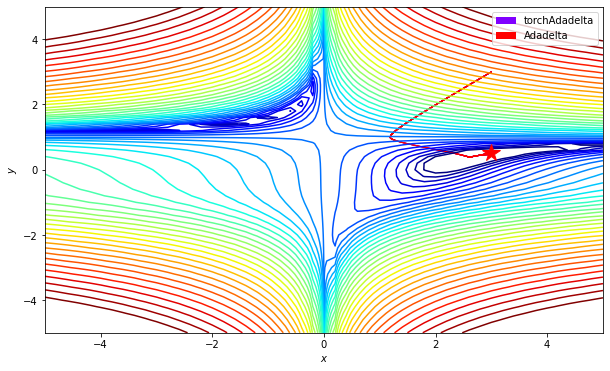

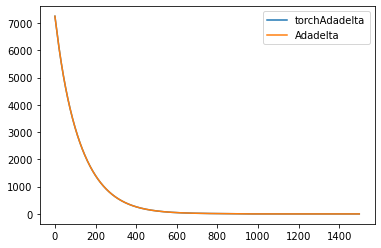

In [ ]:
compare_optimizers(F2 , 
                   [
                       ('torchAdadelta', torchAdadelta, {}),
                       ('Adadelta', Adadelta, {})
                   ], 
                   start_point=[3,3], 
                   minima=(3, 0.5), 
                   num_iter=1500
                  )

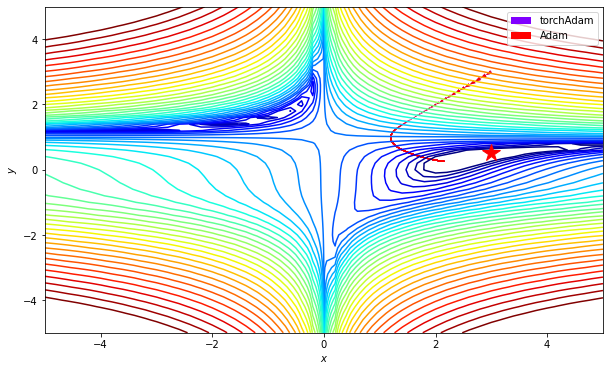

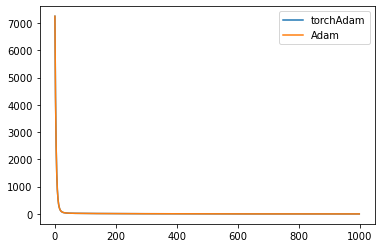

In [ ]:
compare_optimizers(F2 , 
                   [
                       ('torchAdam', torchAdam, dict(lr=1e-1, betas = (0.9, 0.999))),
                       ('Adam', Adam, dict(lr=1e-1))
                   ], 
                   start_point=[3,3], 
                   minima=(3, 0.5), 
                   num_iter=1000
                  )

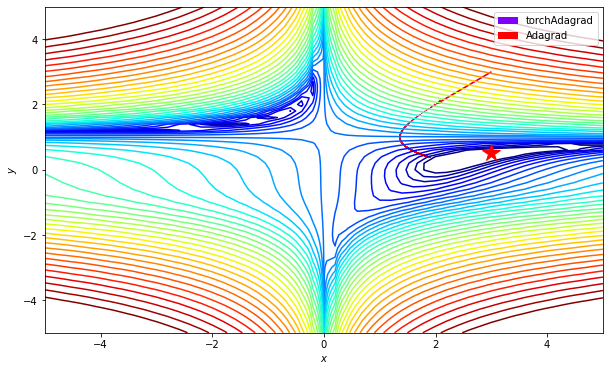

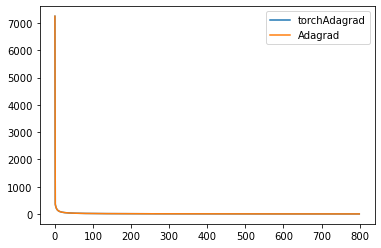

In [ ]:
compare_optimizers(F2, 
                   [
                       ('torchAdagrad', torchAdagrad, dict(lr=1)),
                       ('Adagrad', Adagrad, dict(lr=1))
                   ], 
                   start_point=[3,3], 
                   minima=(3,0.5), 
                   num_iter=800
                  )

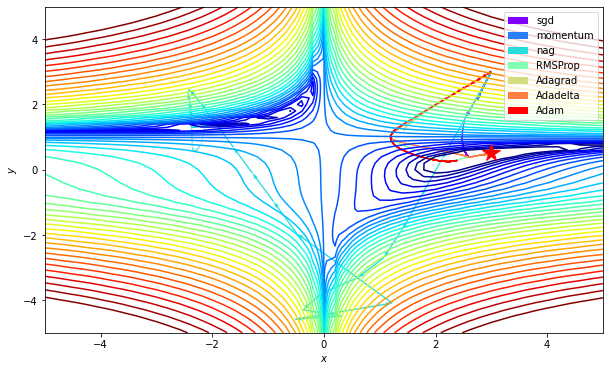

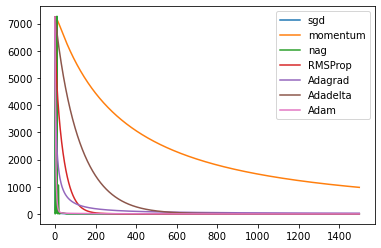

In [ ]:
compare_optimizers(F2, 
                   [
                       ('sgd', SGD, dict(lr=1e-4)),
                       ('momentum', Momentum, dict(lr=1e-4)),
                       ('nag', NAG, dict(lr=1e-4, gamma=0.9)),
                       ('RMSProp', RMSProp, dict(lr=1e-2)),
                       ('Adagrad', Adagrad, dict(lr=0.1)),
                        ('Adadelta', Adadelta, {}),
                        ('Adam', Adam, dict(lr=1e-1))
                   ], 
                   start_point=[3,3], 
                   minima=(3,0.5), 
                   num_iter=1500
                  )

In [ ]:
def J1(x, y):
    return x**2 + y**2

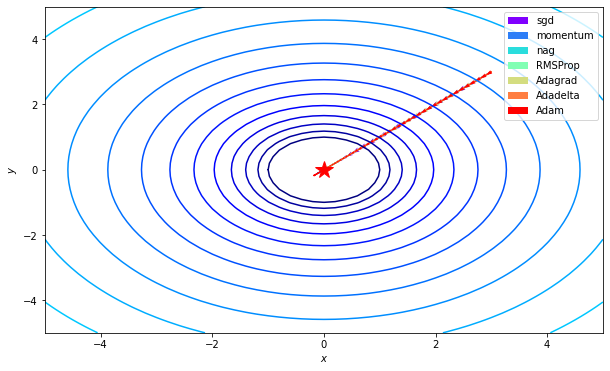

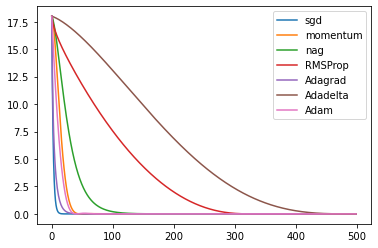

In [ ]:
compare_optimizers(J1, 
                   [
                       ('sgd', SGD, dict(lr=0.1)),
                       ('momentum', Momentum, dict(lr=0.05)),
                       ('nag', NAG, dict(lr=1e-3, gamma=0.9)),
                       ('RMSProp', RMSProp, dict(lr=1e-2)),
                       ('Adagrad', Adagrad, dict(lr=0.5)),
                        ('Adadelta', Adadelta, dict(gamma=0.6)),
                        ('Adam', Adam, dict(lr=1e-1))
                   ], 
                   start_point=[3,3], 
                   minima=(0, 0), 
                   num_iter=500
                  )

In [ ]:
def J2(x, y):
    return x**2*torch.sin(x) + y**2*torch.sin(y)

C:\Users\masha\AppData\Local\Temp/ipykernel_2936/3456689172.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


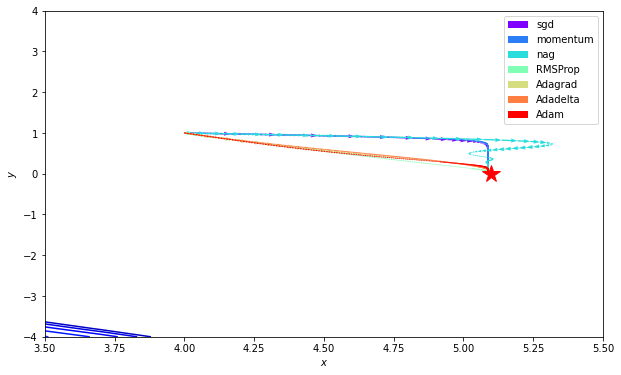

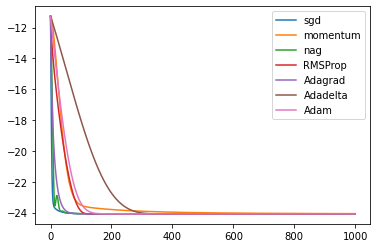

In [ ]:
compare_optimizers(J2, 
                   [
                       ('sgd', SGD, dict(lr=0.01)),
                       ('momentum', Momentum, dict(lr=0.01)),
                       ('nag', NAG, dict(lr=0.001, gamma=0.9)),
                       ('RMSProp', RMSProp, dict(lr=0.01)),
                       ('Adagrad', Adagrad, dict(lr=0.1)),
                        ('Adadelta', Adadelta, dict(gamma=0.9)),
                        ('Adam', Adam, dict(lr=0.01))
                   ], 
                   start_point=[4, 1], 
                   minima=(5.1, 0), 
                   x_range=(3.5, 5.5),
                   y_range=(-4, 4),
                   num_iter=1000
                  )

In [ ]:
def J3(x, y):
    return x**2*torch.sin(x**2) + y**2*torch.sin(y**2)

C:\Users\masha\AppData\Local\Temp/ipykernel_2936/3456689172.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


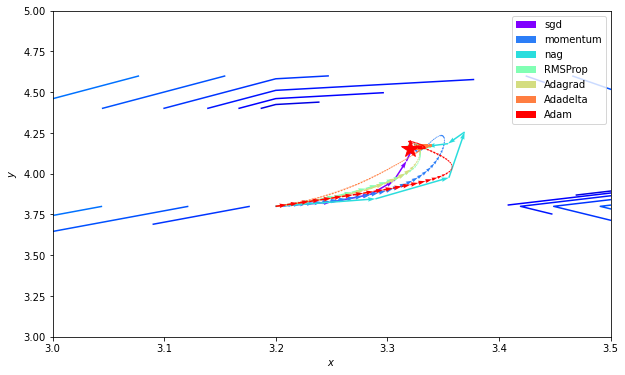

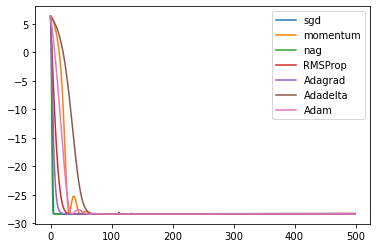

In [ ]:
compare_optimizers(J3, 
                   [
                       ('sgd', SGD, dict(lr=0.001)),
                       ('momentum', Momentum, dict(lr=0.005)),
                       ('nag', NAG, dict(lr=0.001, gamma=0.8)),
                       ('RMSProp', RMSProp, dict(lr=0.01)),
                       ('Adagrad', Adagrad, dict(lr=0.05)),
                        ('Adadelta', Adadelta, dict(gamma=0.7)),
                        ('Adam', Adam, dict(lr=0.01))
                   ], 
                   start_point=[3.2, 3.8], 
                   minima=(3.32, 4.15), 
                   x_range=(3, 3.5),
                   y_range=(3, 5),
                   num_iter=500
                  )

In [12]:
import torch
import random
import torchvision.datasets
import torch.nn as nn

In [14]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
def train(network, loss, optim, epochs=20):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = torch.flatten(X, 1)
            prediction = network(X)
            loss_batch = loss(prediction, y)
            
            losses.append(float(loss_batch))
            loss_batch.backward()
            
            optim.step()
            optim.zero_grad()
            accuracies.append(float((prediction.argmax(dim=1) == y).float().mean()))
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        losses = []
        accuracies = []    
        for X, y in test_loader:
            X = torch.flatten(X, 1)
            prediction = network(X)
            loss_batch = loss(prediction, y)
            losses.append(float(loss_batch))
            accuracies.append(float((prediction.argmax(dim=1) == y).float().mean()))
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
        
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [17]:
 def plot(name, train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

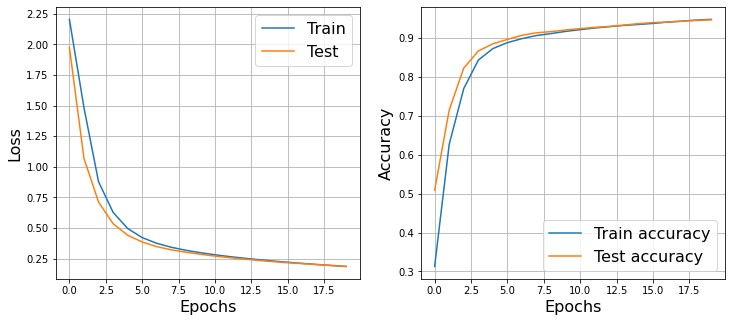

In [40]:
network = nn.Sequential(
    nn.Linear(784, 100), nn.Sigmoid(),
    nn.Linear(100, 100), nn.Sigmoid(),
    nn.Linear(100, 10)
)
loss = nn.CrossEntropyLoss()

optim = SGD(network.parameters(), lr=0.01)
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd = train(network, loss, optim, 20)
plot('SGD', tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd)

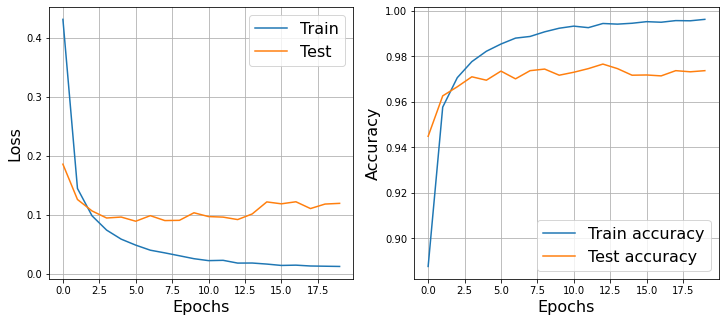

In [38]:
network = nn.Sequential(
    nn.Linear(784, 100), nn.Sigmoid(),
    nn.Linear(100, 100), nn.Sigmoid(),
    nn.Linear(100, 10)
)
loss = nn.CrossEntropyLoss()
optim = Adam(network.parameters(), lr=0.001)
params = network.parameters()
tr_adam, ts_adam, tr_ac_adam, ts_ac_adam = train(network, loss, optim, 20)
plot('Adam', tr_adam, ts_adam, tr_ac_adam, ts_ac_adam)

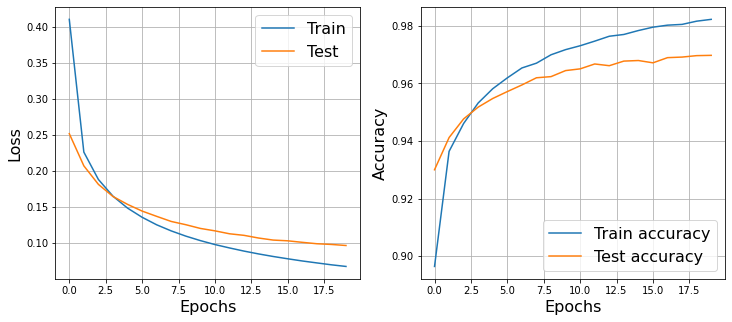

In [41]:
network = nn.Sequential(
    nn.Linear(784, 100), nn.Sigmoid(),
    nn.Linear(100, 100), nn.Sigmoid(),
    nn.Linear(100, 10)
)
loss = nn.CrossEntropyLoss()

optim = Adagrad(network.parameters(), lr=0.01)
tr_adagrad, ts_adagrad, tr_ac_adagrad, ts_ac_adagrad = train(network, loss, optim, 20)
plot('Adagrad', tr_adagrad, ts_adagrad, tr_ac_adagrad, ts_ac_adagrad)

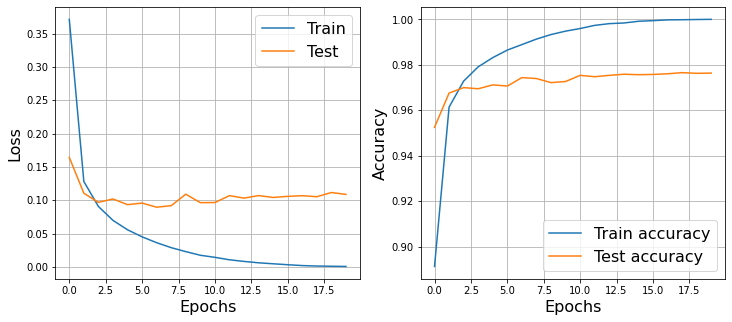

In [43]:
network = nn.Sequential(
    nn.Linear(784, 100), nn.Sigmoid(),
    nn.Linear(100, 100), nn.Sigmoid(),
    nn.Linear(100, 10)
)
loss = nn.CrossEntropyLoss()

optim = Adadelta(network.parameters())
tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta = train(network, loss, optim, 20)
plot('Adadelta', tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta)

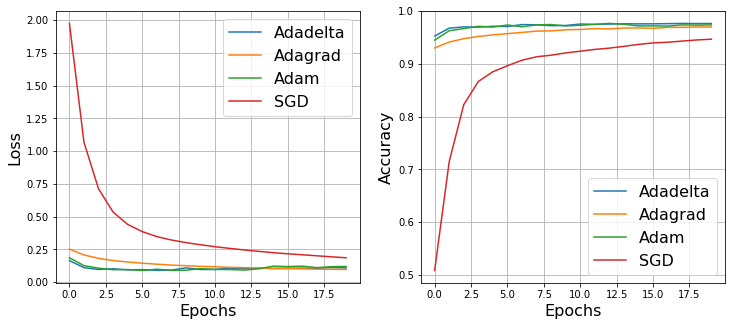

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ts_adadelta, label='Adadelta')
plt.plot(ts_adagrad, label='Adagrad')
plt.plot(ts_adam, label='Adam')
plt.plot(ts_sgd, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(ts_ac_adadelta, label='Adadelta')
plt.plot(ts_ac_adagrad, label='Adagrad')
plt.plot(ts_ac_adam, label='Adam')
plt.plot(ts_ac_sgd, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()


In [45]:
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [48]:
def train_2(network, loss, optim, epochs=20):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for X, y in train_loader:
            prediction = network(X)
            loss_batch = loss(prediction, y)
            
            losses.append(float(loss_batch))
            loss_batch.backward()
            
            optim.step()
            optim.zero_grad()
            accuracies.append(float((prediction.argmax(dim=1) == y).float().mean()))
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        losses = []
        accuracies = []    
        for X, y in test_loader:
            prediction = network(X)
            loss_batch = loss(prediction, y)
            losses.append(float(loss_batch))
            accuracies.append(float((prediction.argmax(dim=1) == y).float().mean()))
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
        
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

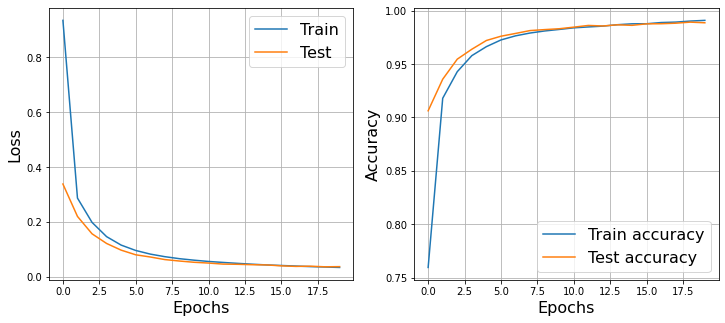

In [49]:
network = model()
loss = nn.CrossEntropyLoss()
optim = SGD(network.parameters(), lr=0.01)
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd = train_2(network, loss, optim, 20)
plot('SGD', tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd)

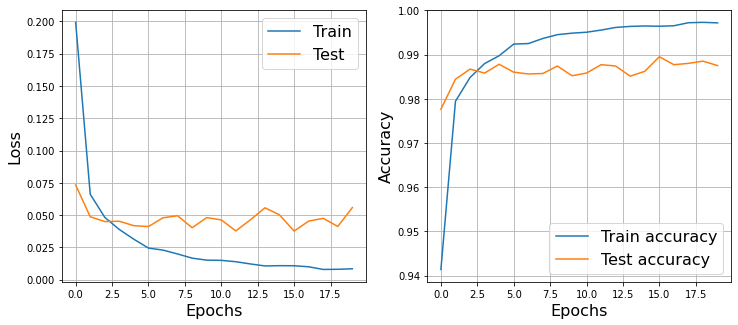

In [53]:
network = model()
loss = nn.CrossEntropyLoss()
optim = Adam(network.parameters(), lr=0.001)
tr_adam, ts_adam, tr_ac_adam, ts_ac_adam = train_2(network, loss, optim, 20)
plot('Adam', tr_adam, ts_adam, tr_ac_adam, ts_ac_adam)

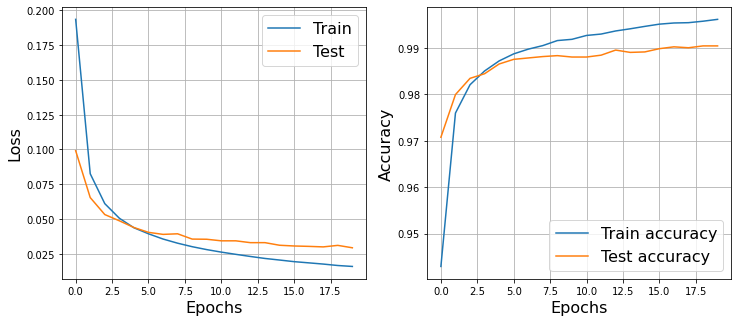

In [54]:
network = model()
loss = nn.CrossEntropyLoss()
optim = Adagrad(network.parameters(), lr=0.01)
tr_adagrad, ts_adagrad, tr_ac_adagrad, ts_ac_adagrad = train_2(network, loss, optim, 20)
plot('Adagrad', tr_adagrad, ts_adagrad, tr_ac_adagrad, ts_ac_adagrad)

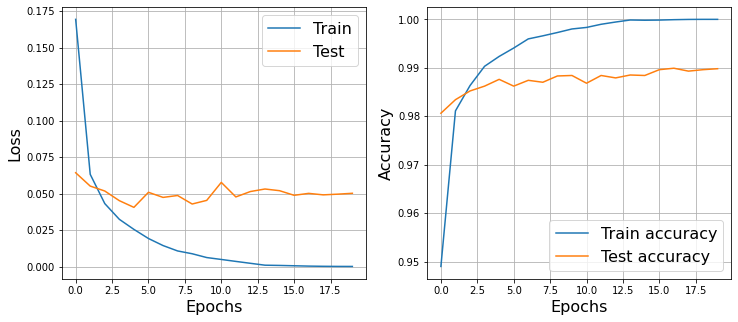

In [55]:
network = model()
loss = nn.CrossEntropyLoss()
optim = Adadelta(network.parameters())
tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta = train_2(network, loss, optim, 20)
plot('Adadelta', tr_adadelta, ts_adadelta, tr_ac_adadelta, ts_ac_adadelta)

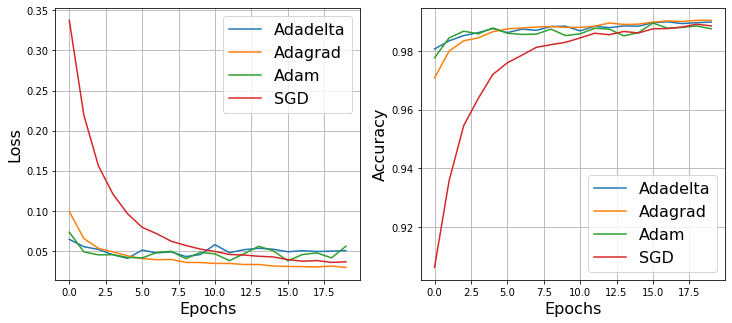

In [56]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ts_adadelta, label='Adadelta')
plt.plot(ts_adagrad, label='Adagrad')
plt.plot(ts_adam, label='Adam')
plt.plot(ts_sgd, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(ts_ac_adadelta, label='Adadelta')
plt.plot(ts_ac_adagrad, label='Adagrad')
plt.plot(ts_ac_adam, label='Adam')
plt.plot(ts_ac_sgd, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()